<center> <h1>Forecasting the amount of 4G data with LinearRegression and fbprophet</h1></center>

<p></p>
<p></p>

<p></p>
<p></p>
<p></p>

# Forecasting with linear regression
##### In this first part, we will train a linear regression model to predict 4G data consumption based on historical data.

## Importing Libraries
##### We start by importing the useful libraries:

In [1]:

from sklearn.model_selection import train_test_split #Split the dataset into the training and the testing datasets
import pandas as pd #Data manipulation and analysis
import plotly.plotly as ply #Data visualization
from fbprophet import Prophet #Forecasting time series
from sklearn.linear_model import LinearRegression
import cufflinks as cf
from datetime import datetime
from sklearn.metrics import r2_score
import numpy as np
cf.go_offline()


## Import data
##### We will import the dataset:

In [2]:

df = pd.read_csv("4G_Data.csv", index_col=0)
df.head()


,Size
Day,
02/07/2015,1923
03/07/2015,2128
04/07/2015,2426
05/07/2015,2117
06/07/2015,2004


In [3]:

#Get a concise data summary
df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 1370 entries, 02/07/2015 to 01/04/2019
Data columns (total 1 columns):
Size    1370 non-null int64
dtypes: int64(1)
memory usage: 21.4+ KB


##### As you can see, the dataset contains two columns (Day and Size) and 1370 rows. the dataset contains information on 4G data consumption for each day.

## Clean data
##### First, we get rid of any instances where there is an empty value:

In [4]:

df.dropna(axis=1, how='all', inplace=True)


In [5]:

#Let's check if there are no missing values
df.isnull().values.any()


False

##### Après, nous devons formater la colonne Day (index) en tant que date :

In [6]:

df.index = pd.to_datetime(df.index, format="%d/%m/%Y")


## Visualisation de données

In [7]:

df.iplot(title="4G Consumption")
#df['Size'] = np.log(df['Size']) #normalization by log
#df.iplot(title="4G Consommation")


## Train/Test Split


##### Linear regression does not work on date type data. So we need to convert it to a numeric value. The following code will convert the date to a numeric value:

In [8]:

df_ordinal=df.copy()
df_ordinal.index = df_ordinal.index.map(datetime.toordinal)
df_ordinal.head()


,Size
Day,
735781,1923
735782,2128
735783,2426
735784,2117
735785,2004


##### We divide our dataset into data to train our model and data to test it.

In [9]:

X = pd.DataFrame(df_ordinal.index)
y = pd.DataFrame(df_ordinal['Size'])

#20% for the test
data_train, data_test, label_train, label_test=train_test_split(X, y, test_size=0.2, random_state=42)

#Let's create a linear regression object
model = LinearRegression()

#Drag the model
reg = model.fit(data_train, label_train)

#Test the model
result = reg.predict(data_test)


## Regression linear model score

In [10]:

print("The score of our model is:", r2_score(label_test,result))


The score of our model is: 0.9430394389883152


## Forecast with Prophet
##### In this part, we are going to train a Prophet model to predict 4G data consumption based on historical data, day of week, weekends and holidays.

In [11]:

df.head()


,Size
Day,
2015-07-02,1923
2015-07-03,2128
2015-07-04,2426
2015-07-05,2117
2015-07-06,2004


## Holidays

##### We add a holiday indicators will help the accuracy of the model. Prophet comes with a Holiday Effects setting that can be provided to the model before training.

##### We will use a Morocco public holiday dataset (from 2015), this dataset is created manually.

In [12]:

holiday_df = pd.read_csv('Holydays_Marocco.csv')
holiday_df.head()


,ds,holiday;;;
0,11/01/2015,Independence Manifesto Day;;;
1,01/05/2015,Labour Day;;;
2,18/07/2015,Eid al-Fitr;;;
3,19/07/2015,Eid al-Fitr;;;
4,30/07/2015,Throne Day;;;


In [13]:

holiday_df.drop(['holiday;;;'], axis=1, inplace=True)
holiday_df['holiday'] = 'MaroccoHoliday'
holiday_df['ds'] = pd.to_datetime(holiday_df['ds'], format="%d/%m/%Y")
holiday_df.head()


,ds,holiday
0,2015-01-11,MaroccoHoliday
1,2015-05-01,MaroccoHoliday
2,2015-07-18,MaroccoHoliday
3,2015-07-19,MaroccoHoliday
4,2015-07-30,MaroccoHoliday


## Train/Test Split


##### We define a training dataset. For this, we use the last 30 entries for prediction and validation purposes.

In [14]:

prediction_size = 30
df_train = df[:-prediction_size]
df_test = df[-prediction_size:]

print(df_train)
print(df_test)


              Size
Day               
2015-07-02    1923
2015-07-03    2128
2015-07-04    2426
2015-07-05    2117
2015-07-06    2004
...            ...
2019-02-26  659410
2019-02-27  687929
2019-02-28  689730
2019-03-01  704968
2019-03-02  764329

[1340 rows x 1 columns]
              Size
Day               
2019-03-03  822660
2019-03-04  703941
2019-03-05  713047
2019-03-06  748717
2019-03-07  729407
2019-03-08  728070
2019-03-09  767497
2019-03-10  819791
2019-03-11  704041
2019-03-12  716889
2019-03-13  755951
2019-03-14  726651
2019-03-15  739964
2019-03-16  777835
2019-03-17  826002
2019-03-18  703742
2019-03-19  700254
2019-03-20  735276
2019-03-21  715847
2019-03-22  741251
2019-03-23  765966
2019-03-24  819186
2019-03-25  704466
2019-03-26  734126
2019-03-27  719313
2019-03-28  701320
2019-03-29  737651
2019-03-30  784783
2019-03-31  815965
2019-04-01  753505


##### Visualization of train and test datasets

In [15]:
_ = df_test.rename(columns={'Size': 'Test'}).join(df_train.rename(columns={'Size': 'Train'}), how='outer').iplot(title="4G Consumption")

##### Prophet requires the Day column to be named ds and the results column to be named y:

In [16]:

df_test.reset_index(inplace=True)
df_train.reset_index(inplace=True)

df_test.columns=['ds','y']
df_train.columns=['ds','y']
df_test.head()


,ds,y
0,2019-03-03,822660
1,2019-03-04,703941
2,2019-03-05,713047
3,2019-03-06,748717
4,2019-03-07,729407


In [17]:

#Créons un objet de Prophet
m = Prophet(holidays=holiday_df, daily_seasonality=False)
m.fit(df_train)


<li> The "make_future_dataframe" function takes two arguments: periods and frequency. In our case, the number of periods should exactly match the length of our test data and the frequency should be set to weekly ("W")

In [18]:

future_frame = m.make_future_dataframe(periods = prediction_size, freq = 'W')

previsions = m.predict (future_frame)
previsions.tail()


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,MaroccoHoliday,MaroccoHoliday_lower,MaroccoHoliday_upper,additive_terms,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1365,2019-08-25,821058.240837,835747.040751,920873.154985,808317.963289,834788.487535,0.000000,0.000000,0.000000,53888.945112,...,28180.103096,28180.103096,28180.103096,25708.842017,25708.842017,25708.842017,0.0,0.0,0.0,874947.185950
1366,2019-09-01,825788.945803,846825.996889,935741.661499,812222.119804,840082.102404,18426.433051,18426.433051,18426.433051,63334.538645,...,28180.103096,28180.103096,28180.103096,16728.002498,16728.002498,16728.002498,0.0,0.0,0.0,889123.484448
1367,2019-09-08,830519.650769,834845.801492,917141.267392,816100.443959,845389.641060,0.000000,0.000000,0.000000,44275.367391,...,28180.103096,28180.103096,28180.103096,16095.264295,16095.264295,16095.264295,0.0,0.0,0.0,874795.018160
1368,2019-09-15,835250.355735,837394.027510,922762.924735,820011.845050,850646.287431,0.000000,0.000000,0.000000,43838.480966,...,28180.103096,28180.103096,28180.103096,15658.377870,15658.377870,15658.377870,0.0,0.0,0.0,879088.836701
1369,2019-09-22,839981.060701,835361.100060,922589.890152,823595.650525,856274.901747,0.000000,0.000000,0.000000,39042.147014,...,28180.103096,28180.103096,28180.103096,10862.043919,10862.043919,10862.043919,0.0,0.0,0.0,879023.207715


<li> Here, <b> yhat </b> represents the prediction, while <b> yhat_lower </b> and <b> yhat_upper </b> represent the lower and upper bound of this prediction respectively.

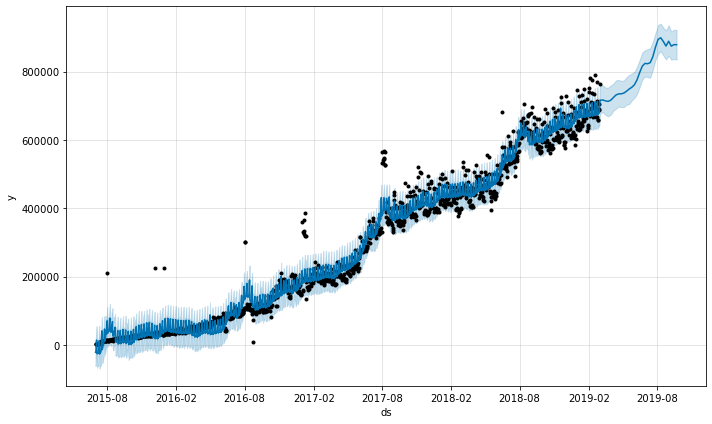

In [19]:

#Forecasting visualization
_ = m.plot (previsions)


<li> As you can see, Prophet just used a blue line to predict 4G consumption in the future.

##### You can also see the characteristics of the time series:

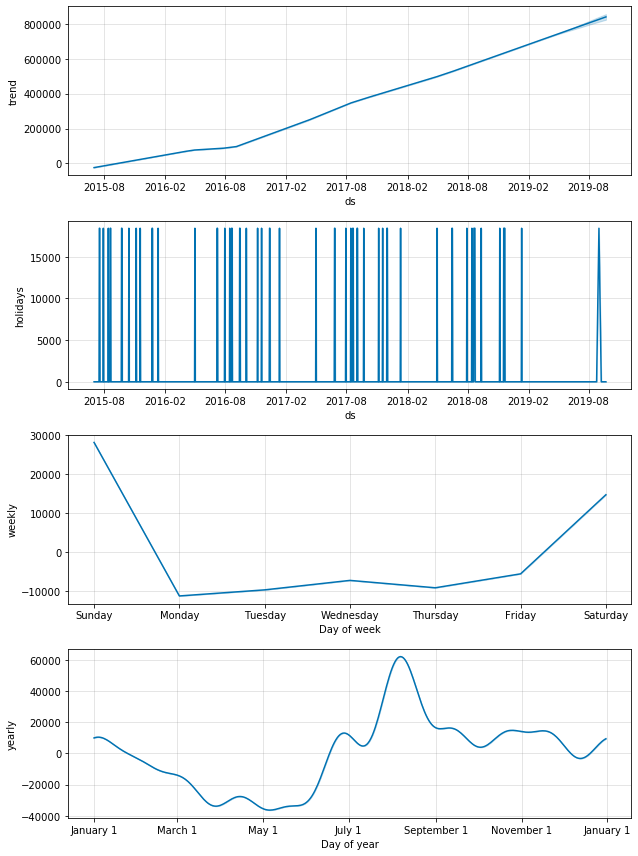

In [20]:

_ = m.plot_components(previsions)


<li> Here, Prophet identified a downward trend, seasonality (weekly and yearly) and the effect of public holidays.

## Score de modele Prophet

In [21]:

result = previsions[['ds', 'yhat']].yhat .apply (lambda x: int (x))
print("The score of our model is:", r2_score(df['Size'],result))


The score of our model is: 0.9788834304719609


In [22]:

teste = pd.DataFrame(["01-01-2020"])
teste.columns=['ds']
teste.head()
prevision = m.predict (teste)
print("The amount of 4G data that will be consumed on 01/01/2020 is:", int(prevision['yhat'][0]))


The amount of 4G data that will be consumed on 01/01/2020 is: 910640
